In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
import tensorflow as tf

from keras.models import Sequential,load_model
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, GaussianNoise, Activation
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical 
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
#data function for reading and processing the train and test sets
#necessary as an input for the optimisation algorithm
def data():
    #define input processing function
    def process_attributes(df, train, test):
        
        #define and fit the scaler to the full dataset
        cs = MinMaxScaler()
        cs.fit(df_inputs.select_dtypes(np.number))
        
        #scale the numerical input variables
        trainContinuous = cs.transform(train.select_dtypes(np.number))
        testContinuous = cs.transform(test.select_dtypes(np.number))
        
        if 'Gender' in df.columns:
            
            #uncomment the code below to accommodate for any categorical columns
            zipBinarizer = LabelBinarizer().fit(df["Gender"])
            trainCategorical = zipBinarizer.transform(train["Gender"])
            testCategorical = zipBinarizer.transform(test["Gender"])

            # construct our training and testing data points by concatenating
            # the categorical features with the continuous features
            trainX = np.hstack([trainContinuous, trainCategorical])
            testX = np.hstack([testContinuous, testCategorical])
            
        else:
            trainX=trainContinuous
            testX=testContinuous
        
        # return the concatenated training and testing data
        return (trainX, testX)
    
    #read the excel datasets
    df = pd.read_excel('Cleaned_Dataframe_WithoutAge.xlsx')
    df.set_index('Sample',inplace=True)
    features=df.columns


    #separate cancer markers and input data
    df_outputs= df['Status']
    df_inputs = df.drop('Status',axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(df_inputs, df_outputs, random_state=100, stratify=df_outputs, test_size=0.3)
    
    #process the input sets
    (X_train_sc, X_test_sc) = process_attributes(df_inputs, X_train, X_test)
    
    #encode the categorical output variables
    #encode categorical outputs
    lb = LabelBinarizer()
    lb.fit(y_train)
    train_outputs= lb.transform(y_train)
    test_outputs= lb.transform(y_test)

    Y_train = tf.keras.utils.to_categorical(train_outputs)
    Y_test = tf.keras.utils.to_categorical(test_outputs)

    return X_train_sc, Y_train, X_test_sc, Y_test, lb, features

In [3]:
#define model and search space for the optimisation algorithm
def model(X_train_sc, Y_train, X_test_sc, Y_test):
    
    #define ANN model and search space
    def ANN():
        
        #define first two layers, possible alternatives for neurons in each,
        #activation function, and dropout layers
        model=Sequential()
        Dropout_rate={{uniform(0, 0.3)}}
        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))

        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))
        
        #define output layer of the model
        
        model.add(Dense(2))
        model.add(Activation('softmax'))
        
        #define optimisation algorithm for network training
        optim=tf.keras.optimizers.Adam(learning_rate={{choice([ 0.001, 0.0005, 0.0001])}})
        
        #compile model and return it
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
        
        return model 
    
    #encode and transform labels for model training
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(np.argmax(Y_train,axis=1))
    
    #call the ANN and ddefine training epochs; define batch size alternatives
    net = KerasClassifier(build_fn = ANN,
                                 epochs={{choice([50,100,200])}},
                                 batch_size= {{choice([32,64])}},
                                 verbose = 0)
    model = ANN()
    
    #set up cross-validation scoring, and returned variables
    c = cross_val_score(net,
                    X_train_sc, y,
                    cv= StratifiedKFold(n_splits=5, shuffle=True),
                    scoring='accuracy').mean()
    print('Test accuracy:', c)
    return {'loss': -c, 'status': STATUS_OK, 'model': model}

In [4]:
#call in data function for test evaluation later
X_train, Y_train, X_test, Y_test, lb, features = data()
print('The model uses the following features:', features)

The model uses the following features: Index(['GP1', 'GP2', 'GP3', 'GP4', 'GP5', 'GP6', 'GP7', 'GP8', 'GP9', 'GP10',
       'GP11', 'GP12', 'GP13', 'GP14', 'GP15', 'GP16', 'GP17', 'GP18', 'GP19',
       'GP20', 'GP21', 'GP22', 'GP23', 'GP24', 'Gender', 'Status'],
      dtype='object')


In [5]:
#call the optimisation algorithm
best_run, best_model = optim.minimize(model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=Trials(),
                                      notebook_name='ANN_Optimisation_WithoutAge')

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.pipeline import Pipeline
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
except:
    pass

try:
    from sklearn.compose import make_column_selector as selector
except:
    pass

try:
    from sklearn.compose import ColumnTransformer
except:
    pass

try:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras.models 

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                        
0.754546669875137                                     
  2%|▏         | 1/50 [01:12<59:24, 72.75s/trial, best loss: -0.754546669875137]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                  
0.7654929012593247                                                              
  4%|▍         | 2/50 [01:56<44:42, 55.88s/trial, best loss: -0.7654929012593247]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7655410283147509                                                               
  6%|▌         | 3/50 [02:44<40:56, 52.26s/trial, best loss: -0.7655410283147509]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7677201144354429                                                               
  8%|▊         | 4/50 [03:11<32:16, 42.10s/trial, best loss: -0.7677201144354429]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7574743990802385                                                               
 10%|█         | 5/50 [03:47<29:59, 40.00s/trial, best loss: -0.7677201144354429]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7567712093259539                                                               
 12%|█▏        | 6/50 [04:39<32:11, 43.90s/trial, best loss: -0.7677201144354429]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7655169647870378                                                               
 14%|█▍        | 7/50 [05:07<27:50, 38.86s/trial, best loss: -0.7677201144354429]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7253469158578648                                                               
 16%|█▌        | 8/50 [05:31<23:51, 34.08s/trial, best loss: -0.7677201144354429]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.769917916633245                                                                
 18%|█▊        | 9/50 [06:15<25:24, 37.18s/trial, best loss: -0.769917916633245] 

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                  
0.7582096735381407                                                              
 20%|██        | 10/50 [06:32<20:44, 31.10s/trial, best loss: -0.769917916633245]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7611374027432423                                                               
 22%|██▏       | 11/50 [07:21<23:46, 36.57s/trial, best loss: -0.769917916633245]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7692013582524531                                                               
 24%|██▍       | 12/50 [07:43<20:18, 32.05s/trial, best loss: -0.769917916633245]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7669794925269378                                                               
 26%|██▌       | 13/50 [08:18<20:16, 32.89s/trial, best loss: -0.769917916633245]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.766963450175129                                                                
 28%|██▊       | 14/50 [08:48<19:11, 31.98s/trial, best loss: -0.769917916633245]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7253469158578648                                                               
 30%|███       | 15/50 [09:06<16:09, 27.70s/trial, best loss: -0.769917916633245]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7552926392342451                                                               
 32%|███▏      | 16/50 [09:38<16:25, 29.00s/trial, best loss: -0.769917916633245]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7348359669527553                                                               
 34%|███▍      | 17/50 [09:59<14:37, 26.59s/trial, best loss: -0.769917916633245]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.761113339215529                                                                
 36%|███▌      | 18/50 [10:16<12:40, 23.78s/trial, best loss: -0.769917916633245]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7713563808454319                                                               
 38%|███▊      | 19/50 [10:43<12:52, 24.91s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.762610625384348                                                                 
 40%|████      | 20/50 [11:33<16:09, 32.30s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7567712093259539                                                                
 42%|████▏     | 21/50 [11:55<14:04, 29.12s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7582444319670596                                                                
 44%|████▍     | 22/50 [12:15<12:22, 26.51s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7669901874281436                                                                
 46%|████▌     | 23/50 [13:03<14:48, 32.90s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7436057859415524                                                                
 48%|████▊     | 24/50 [13:23<12:40, 29.24s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7655276596882437                                                                
 50%|█████     | 25/50 [13:48<11:32, 27.71s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7465308414213523                                                                
 52%|█████▏    | 26/50 [14:31<12:57, 32.39s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7311890056415604                                                                
 54%|█████▍    | 27/50 [15:19<14:14, 37.17s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7684473677174407                                                                
 56%|█████▌    | 28/50 [15:42<12:01, 32.79s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7355739151359589                                                                
 58%|█████▊    | 29/50 [16:08<10:44, 30.67s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7662629341461458                                                                
 60%|██████    | 30/50 [16:59<12:19, 36.99s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7655062698858319                                                                
 62%|██████▏   | 31/50 [17:53<13:17, 41.95s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7538408063955508                                                                
 64%|██████▍   | 32/50 [18:15<10:50, 36.17s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7552926392342451                                                                
 66%|██████▌   | 33/50 [18:47<09:51, 34.82s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7640785005748509                                                                
 68%|██████▊   | 34/50 [19:37<10:27, 39.23s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7669875137028421                                                                
 70%|███████   | 35/50 [20:30<10:49, 43.33s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.760396780834737                                                                 
 72%|███████▏  | 36/50 [21:18<10:26, 44.74s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7268094435977648                                                                
 74%|███████▍  | 37/50 [21:53<09:07, 42.09s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.765535680864148                                                                 
 76%|███████▌  | 38/50 [22:16<07:16, 36.36s/trial, best loss: -0.7713563808454319]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7728269297612363                                                                
 78%|███████▊  | 39/50 [23:01<07:06, 38.80s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7297264779016605                                                                
 80%|████████  | 40/50 [23:18<05:23, 32.35s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7655223122376407                                                                
 82%|████████▏ | 41/50 [24:03<05:25, 36.12s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7640571107724392                                                                
 84%|████████▍ | 42/50 [24:33<04:32, 34.11s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7648030801315473                                                                
 86%|████████▌ | 43/50 [24:51<03:25, 29.38s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7655410283147509                                                                
 88%|████████▊ | 44/50 [25:41<03:32, 35.46s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7538327852196466                                                                
 90%|█████████ | 45/50 [26:02<02:36, 31.32s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7720836341274298                                                                
 92%|█████████▏| 46/50 [26:26<01:56, 29.02s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7574797465308414                                                                
 94%|█████████▍| 47/50 [26:52<01:24, 28.20s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7611400764685436                                                                
 96%|█████████▌| 48/50 [27:16<00:53, 26.94s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7699045480067378                                                                
 98%|█████████▊| 49/50 [27:38<00:25, 25.27s/trial, best loss: -0.7728269297612363]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
100%|██████████| 50/50 [28:01<00:00, 33.63s/trial, best loss: -0.7728269297612363]


In [6]:
#display the parameters for the best performing model
print(best_run)

{'Activation': 1, 'Activation_1': 0, 'Dense': 0, 'Dense_1': 0, 'Dropout_rate': 0.03006344708238111, 'batch_size': 0, 'epochs': 2, 'learning_rate': 0}


In [7]:
best_model

In [8]:
#train the model to gt learning curves
batch=[32,64]
ep=[50,100,200]

history = best_model.fit(
    X_train, Y_train,
    batch_size=batch[best_run['batch_size']],
    epochs=ep[best_run['epochs']],
    verbose=1,
    validation_data=(X_test, Y_test),
    shuffle=False)

Epoch 1/200
43/43 [==============================] - 3s 24ms/step - loss: 0.6496 - accuracy: 0.7161 - val_loss: 0.6162 - val_accuracy: 0.7245
Epoch 2/200
43/43 [==============================] - 0s 4ms/step - loss: 0.6024 - accuracy: 0.7394 - val_loss: 0.5896 - val_accuracy: 0.7245
Epoch 3/200
43/43 [==============================] - 0s 3ms/step - loss: 0.5761 - accuracy: 0.7395 - val_loss: 0.5815 - val_accuracy: 0.7245
Epoch 4/200
43/43 [==============================] - 0s 3ms/step - loss: 0.5697 - accuracy: 0.7395 - val_loss: 0.5785 - val_accuracy: 0.7245
Epoch 5/200
43/43 [==============================] - 0s 3ms/step - loss: 0.5663 - accuracy: 0.7395 - val_loss: 0.5756 - val_accuracy: 0.7245
Epoch 6/200
43/43 [==============================] - 0s 3ms/step - loss: 0.5592 - accuracy: 0.7395 - val_loss: 0.5724 - val_accuracy: 0.7245
Epoch 7/200
43/43 [==============================] - 0s 3ms/step - loss: 0.5561 - accuracy: 0.7395 - val_loss: 0.5691 - val_accuracy: 0.7245
Epoch 8/200


Epoch 59/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4781 - accuracy: 0.7579 - val_loss: 0.5058 - val_accuracy: 0.7432
Epoch 60/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4776 - accuracy: 0.7712 - val_loss: 0.5056 - val_accuracy: 0.7415
Epoch 61/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4760 - accuracy: 0.7670 - val_loss: 0.5058 - val_accuracy: 0.7381
Epoch 62/200
43/43 [==============================] - 0s 3ms/step - loss: 0.4854 - accuracy: 0.7519 - val_loss: 0.5055 - val_accuracy: 0.7449
Epoch 63/200
43/43 [==============================] - 0s 3ms/step - loss: 0.4816 - accuracy: 0.7626 - val_loss: 0.5054 - val_accuracy: 0.7381
Epoch 64/200
43/43 [==============================] - 0s 4ms/step - loss: 0.4753 - accuracy: 0.7765 - val_loss: 0.5053 - val_accuracy: 0.7449
Epoch 65/200
43/43 [==============================] - 0s 3ms/step - loss: 0.4848 - accuracy: 0.7630 - val_loss: 0.5052 - val_accuracy: 0.7466
Epoch 

43/43 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.7773 - val_loss: 0.5010 - val_accuracy: 0.7466
Epoch 117/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4624 - accuracy: 0.7785 - val_loss: 0.5012 - val_accuracy: 0.7432
Epoch 118/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4713 - accuracy: 0.7864 - val_loss: 0.5010 - val_accuracy: 0.7432
Epoch 119/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4684 - accuracy: 0.7824 - val_loss: 0.5011 - val_accuracy: 0.7449
Epoch 120/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4750 - accuracy: 0.7818 - val_loss: 0.5010 - val_accuracy: 0.7449
Epoch 121/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7867 - val_loss: 0.5008 - val_accuracy: 0.7432
Epoch 122/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4663 - accuracy: 0.7818 - val_loss: 0.5006 - val_accuracy: 0.7483
Epoch 123/200

43/43 [==============================] - 0s 2ms/step - loss: 0.4659 - accuracy: 0.7839 - val_loss: 0.5008 - val_accuracy: 0.7449
Epoch 174/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4624 - accuracy: 0.7782 - val_loss: 0.4999 - val_accuracy: 0.7517
Epoch 175/200
43/43 [==============================] - 0s 3ms/step - loss: 0.4652 - accuracy: 0.7806 - val_loss: 0.5000 - val_accuracy: 0.7517
Epoch 176/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4579 - accuracy: 0.7927 - val_loss: 0.5007 - val_accuracy: 0.7466
Epoch 177/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4663 - accuracy: 0.7937 - val_loss: 0.4999 - val_accuracy: 0.7500
Epoch 178/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4580 - accuracy: 0.7985 - val_loss: 0.5004 - val_accuracy: 0.7483
Epoch 179/200
43/43 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.7895 - val_loss: 0.5003 - val_accuracy: 0.7517
Epoch 180/200

In [9]:
#save resulting model in callable file
best_model.summary()
best_model.save('ANN Models/all_inputs_WithoutAge_model.h5')
print("Saved model to directory")

Model: "sequential_228"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_684 (Dense)            (None, 8)                 208       
_________________________________________________________________
activation_684 (Activation)  (None, 8)                 0         
_________________________________________________________________
dropout_456 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_685 (Dense)            (None, 8)                 72        
_________________________________________________________________
activation_685 (Activation)  (None, 8)                 0         
_________________________________________________________________
dropout_457 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_686 (Dense)            (None, 2)              

In [10]:
#Calculate the labels for the test set
predictions = best_model.predict(X_test)

In [11]:
#evaluate test performance of the model
print('Cancer is encoded by',lb.transform(['Cancer']), ', while Control is encoded by',lb.transform(['Control']))
print(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1)))
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1), target_names=lb.classes_))

Cancer is encoded by [[0]] , while Control is encoded by [[1]]
[[380  46]
 [100  62]]
              precision    recall  f1-score   support

      Cancer       0.79      0.89      0.84       426
     Control       0.57      0.38      0.46       162

    accuracy                           0.75       588
   macro avg       0.68      0.64      0.65       588
weighted avg       0.73      0.75      0.73       588



In [12]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


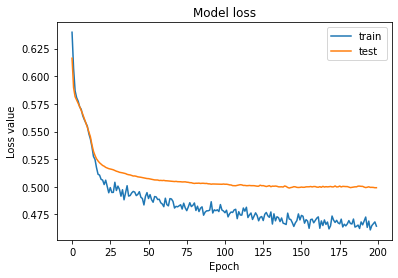

In [13]:
from matplotlib import pyplot as plt
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

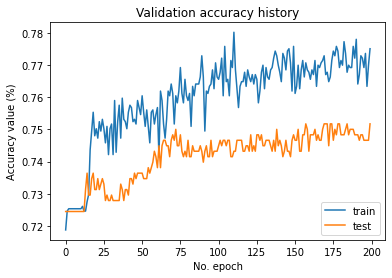

In [14]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()